<a href="https://colab.research.google.com/github/edwin-yan/Passion-Fruit-Disease-Detection/blob/andrew/Roboflow_TensorFlow2_Object_Detection_v2_invert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction


In this notebook, we implement [The TensorFlow 2 Object Detection Library](https://blog.tensorflow.org/2020/07/tensorflow-2-meets-object-detection-api.html) for training on your own dataset.

We also recommend reading our blog post on [Train TensorFlow 2 Object Detection on custom data](https://blog.roboflow.com/train-a-tensorflow2-object-detection-model/) side by side.

We will take the following steps to implement YOLOv4 on our custom data:
* Install TensorFlow2 Object Detection Dependencies
* Download Custom TensorFlow2 Object Detection Dataset
* Write Custom TensorFlow2 Object Detection Training Configuation
* Train Custom TensorFlow2 Object Detection Model
* Export Custom TensorFlow2 Object Detection Weights
* Use Trained TensorFlow2 Object Detection For Inference on Test Images

When you are done you will have a custom detector that you can use. It will make inference like this:

#### ![Roboflow Workmark](https://i.imgur.com/L0n564N.png)

### **Reach out for support**

If you run into any hurdles on your own data set or just want to share some cool results in your own domain, [reach out!](https://roboflow.ai) 



#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)

In [45]:
from google.colab import drive
drive.mount('/content/drive')
colabPath = '/content/drive/MyDrive/JHU/DNN/FinalProject'
testImgPath = f'{colabPath}/Test_Images/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
import time
t0 = time.time()

In [47]:
!gdown --id 1Ir5wDGtE5muo4zLx6qiL90Q0e8-Nzmf8
!dpkg -i libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb
!ls -l /usr/lib/x86_64-linux-gnu/libcudnn.so.8*


Downloading...
From: https://drive.google.com/uc?id=1Ir5wDGtE5muo4zLx6qiL90Q0e8-Nzmf8
To: /content/test/libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb
100% 430M/430M [00:03<00:00, 118MB/s] 
(Reading database ... 155220 files and directories currently installed.)
Preparing to unpack libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb ...
Unpacking libcudnn8 (8.1.0.77-1+cuda11.2) over (8.1.0.77-1+cuda11.2) ...
Setting up libcudnn8 (8.1.0.77-1+cuda11.2) ...
Processing triggers for libc-bin (2.27-3ubuntu1.3) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

lrwxrwxrwx 1 root root     17 Jan 24  2021 /usr/lib/x86_64-linux-gnu/libcudnn.so.8 -> libcudnn.so.8.1.0
-rw-r--r-- 1 root root 158264 Jan 24  2021 /usr/lib/x86_64-linux-gnu/libcudnn.so.8.1.0


In [48]:
!python -m pip install --upgrade pip

# Install TensorFlow2 Object Detection Dependencies

In [49]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Modified slightly since pip install was taking a while and I wanted to see what was being installed

In [50]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .


In [51]:
% cd models/research/
! ls

/content/test/models/research
adversarial_text    cvt_text	   lstm_object_detection      README.md
attention_ocr	    deeplab	   marco		      rebar
audioset	    deep_speech    nst_blogpost		      seq_flow_lite
autoaugment	    delf	   object_detection	      setup.py
build		    efficient-hrl  object_detection.egg-info  slim
cognitive_planning  lfads	   pcl_rl		      vid2depth


In [52]:
! python -m pip install .

Processing /content/test/models/research
  Preparing metadata (setup.py) ... done
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=21900336 sha256=aa9a00f8ea8e46cae99ea0e9d3f066c720f81c01b252d7f7c465101fb88bfd27
  Stored in directory: /tmp/pip-ephem-wheel-cache-jt7xtxx8/wheels/a5/77/c9/2a1688553483bd39ee2f94e38d446905b13246e8f9e374a86f
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [53]:
!pip --version

pip 21.3.1 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)


In [54]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [55]:
#run model builder test
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py


2021-11-18 17:00:36.766541: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-18 17:00:36.775207: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-18 17:00:36.775783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
Running tests under Python 3.7.12: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2021-11-18 17:00:36.783420: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-criti

In [56]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

# Prepare Tensorflow 2 Object Detection Training Data


Roboflow automatically creates our TFRecord and label_map files that we need!

**Generating your own TFRecords the only step you need to change for your own custom dataset.**

Because we need one TFRecord file for our training data, and one TFRecord file for our test data, we'll create two separate datasets in Roboflow and generate one set of TFRecords for each.

To create a dataset in Roboflow and generate TFRecords, follow [this step-by-step guide](https://blog.roboflow.ai/getting-started-with-roboflow/).




![](https://i.imgur.com/ZwMdcbY.png)

In [57]:
# #follow the link below to get your download code from from Roboflow
# !pip install -q roboflow
# from roboflow import Roboflow
# rf = Roboflow(model_format="tfrecord", notebook="roboflow-tf2-od")

In [58]:
# #Downloading data from Roboflow
# from roboflow import Roboflow
# rf = Roboflow(api_key="YOUR_API_KEY")
# project = rf.workspace().project("YOUR_PROJECT")
# dataset = project.version("YOUR_VERSION").download("tfrecord")

In [59]:
# NOTE: Update these TFRecord names from "cells" and "cells_label_map" to your files!
# test_record_fname = dataset.location + '/test/cells.tfrecord'
# train_record_fname = dataset.location + '/train/cells.tfrecord'
# label_map_pbtxt_fname = dataset.location + '/train/cells_label_map.pbtxt'
test_record_fname =   f'{colabPath}/AndrewInvertedTFRecords/val_inverted.record'
train_record_fname = f'{colabPath}/AndrewInvertedTFRecords/train_inverted.record'
label_map_pbtxt_fname = f'{colabPath}/labelmap.pbtxt'

# Configure Custom TensorFlow2 Object Detection Training Configuration




> In this section you can specify any model in the [TF2 OD model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md) and set up your training configuration.



In [60]:
##change chosen model to deploy different models available in the TF2 object detection zoo
MODELS_CONFIG = {
    'efficientdet-d0': {
        'model_name': 'efficientdet_d0_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d0_512x512_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d0_coco17_tpu-32.tar.gz',
        'batch_size': 16
    },
    'efficientdet-d1': {
        'model_name': 'efficientdet_d1_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d1_640x640_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d1_coco17_tpu-32.tar.gz',
        'batch_size': 16
    },
    'efficientdet-d2': {
        'model_name': 'efficientdet_d2_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d2_768x768_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d2_coco17_tpu-32.tar.gz',
        'batch_size': 16
    },
        'efficientdet-d3': {
        'model_name': 'efficientdet_d3_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d3_896x896_coco17_tpu-32.config',
        'pretrained_checkpoint': 'efficientdet_d3_coco17_tpu-32.tar.gz',
        'batch_size': 16
    }
}

#in this tutorial we implement the lightweight, smallest state of the art efficientdet model
#if you want to scale up tot larger efficientdet models you will likely need more compute!
chosen_model = 'efficientdet-d0'

num_steps = 10000 #The more steps, the longer the training. Increase if your loss function is still decreasing and validation metrics are increasing. 
num_eval_steps = 500 #Perform evaluation after so many steps

model_name = MODELS_CONFIG[chosen_model]['model_name']
pretrained_checkpoint = MODELS_CONFIG[chosen_model]['pretrained_checkpoint']
base_pipeline_file = MODELS_CONFIG[chosen_model]['base_pipeline_file']
batch_size = MODELS_CONFIG[chosen_model]['batch_size'] #if you can fit a large batch in memory, it may speed up your training

In [61]:
#download pretrained weights
%mkdir /content/models/research/deploy/
%cd /content/models/research/deploy/
import tarfile
download_tar = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/' + pretrained_checkpoint

!wget {download_tar}
tar = tarfile.open(pretrained_checkpoint)
tar.extractall()
tar.close()

mkdir: cannot create directory ‘/content/models/research/deploy/’: File exists
/content/models/research/deploy
--2021-11-18 17:01:01--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.145.128, 2a00:1450:4013:c14::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.145.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30736482 (29M) [application/x-tar]
Saving to: ‘efficientdet_d0_coco17_tpu-32.tar.gz.3’

efficientdet_d0_coc 100%[===================>]  29.31M  --.-KB/s    in 0.1s    

2021-11-18 17:01:01 (203 MB/s) - ‘efficientdet_d0_coco17_tpu-32.tar.gz.3’ saved [30736482/30736482]



In [62]:
#download base training configuration file
%cd /content/models/research/deploy
download_config = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/' + base_pipeline_file
!wget {download_config}

/content/models/research/deploy
--2021-11-18 17:01:01--  https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/ssd_efficientdet_d0_512x512_coco17_tpu-8.config
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4630 (4.5K) [text/plain]
Saving to: ‘ssd_efficientdet_d0_512x512_coco17_tpu-8.config.3’

ssd_efficientdet_d0 100%[===================>]   4.52K  --.-KB/s    in 0s      

2021-11-18 17:01:02 (66.5 MB/s) - ‘ssd_efficientdet_d0_512x512_coco17_tpu-8.config.3’ saved [4630/4630]



In [63]:
#prepare
pipeline_fname = '/content/models/research/deploy/' + base_pipeline_file
fine_tune_checkpoint = '/content/models/research/deploy/' + model_name + '/checkpoint/ckpt-0'

def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())
num_classes = get_num_classes(label_map_pbtxt_fname)


In [64]:
#write custom configuration file by slotting our dataset, model checkpoint, and training parameters into the base pipeline file

import re

%cd /content/models/research/deploy
print('writing custom configuration file')

with open(pipeline_fname) as f:
    s = f.read()
with open('pipeline_file.config', 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    
    #fine-tune checkpoint type
    s = re.sub(
        'fine_tune_checkpoint_type: "classification"', 'fine_tune_checkpoint_type: "{}"'.format('detection'), s)
        
    f.write(s)



/content/models/research/deploy
writing custom configuration file


In [65]:
%cat /content/models/research/deploy/pipeline_file.config

 # SSD with EfficientNet-b0 + BiFPN feature extractor,
# shared box predictor and focal loss (a.k.a EfficientDet-d0).
# See EfficientDet, Tan et al, https://arxiv.org/abs/1911.09070
# See Lin et al, https://arxiv.org/abs/1708.02002
# Trained on COCO, initialized from an EfficientNet-b0 checkpoint.
#
# Train on TPU-8

model {
  ssd {
    inplace_batchnorm_update: true
    freeze_batchnorm: false
    num_classes: 3
    add_background_class: false
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    encode_background_as_zeros: true
    anchor_generator {
      m

In [66]:
pipeline_file = '/content/models/research/deploy/pipeline_file.config'
model_dir = '/content/training/'

# Train Custom TF2 Object Detector

* pipeline_file: defined above in writing custom training configuration
* model_dir: the location tensorboard logs and saved model checkpoints will save to
* num_train_steps: how long to train for
* num_eval_steps: perform eval on validation set after this many steps







In [67]:
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --sample_1_of_n_eval_examples=1 \
    --num_eval_steps={num_eval_steps}

2021-11-18 17:01:05.054837: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-18 17:01:05.063261: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-18 17:01:05.063828: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-18 17:01:05.064757: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [68]:
#run model evaluation to obtain performance metrics
#!python /content/models/research/object_detection/model_main_tf2.py \
    #--pipeline_config_path={pipeline_file} \
    #--model_dir={model_dir} \
    #--checkpoint_dir={model_dir} \
#Not yet implemented for EfficientDet

In [69]:
%load_ext tensorboard
%tensorboard --logdir '/content/training/train'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 566), started 3:20:51 ago. (Use '!kill 566' to kill it.)

<IPython.core.display.Javascript object>

## Exporting a Trained Inference Graph
Still to come for TF2 models, we will be updating this Colab notebook accordingly as the functionality is added. 

In [70]:
#see where our model saved weights
%ls '/content/training/'

checkpoint                   ckpt-6.index
ckpt-10.data-00000-of-00001  ckpt-7.data-00000-of-00001
ckpt-10.index                ckpt-7.index
ckpt-11.data-00000-of-00001  ckpt-8.data-00000-of-00001
ckpt-11.index                ckpt-8.index
ckpt-12.data-00000-of-00001  ckpt-9.data-00000-of-00001
ckpt-12.index                ckpt-9.index
ckpt-6.data-00000-of-00001   train/


In [71]:
#run conversion script
import re
import numpy as np

output_directory = '/content/fine_tuned_model'

#place the model weights you would like to export here
last_model_path = '/content/training/'
print(last_model_path)
!python /content/models/research/object_detection/exporter_main_v2.py \
    --trained_checkpoint_dir {last_model_path} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_file}

/content/training/
2021-11-18 19:31:30.793812: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-18 19:31:30.841020: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-18 19:31:30.841689: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-18 19:31:30.849585: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the

In [72]:
%ls '/content/fine_tuned_model/saved_model/'

assets/  saved_model.pb  variables/


# Run Inference on Test Images with Custom TensorFlow2 Object Detector

In [73]:
#downloading test images from Roboflow
#export dataset above with format COCO JSON
#or import your test images via other means. 
%mkdir /content/test/
%cd /content/test/
# !curl -L "[YOUR LINK HERE]" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

mkdir: cannot create directory ‘/content/test/’: File exists
/content/test


In [74]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [75]:
%ls '/content/training/'

checkpoint                   ckpt-6.index
ckpt-10.data-00000-of-00001  ckpt-7.data-00000-of-00001
ckpt-10.index                ckpt-7.index
ckpt-11.data-00000-of-00001  ckpt-8.data-00000-of-00001
ckpt-11.index                ckpt-8.index
ckpt-12.data-00000-of-00001  ckpt-9.data-00000-of-00001
ckpt-12.index                ckpt-9.index
ckpt-6.data-00000-of-00001   train/


In [76]:
import pathlib

filenames = list(pathlib.Path('/content/training/').glob('*.index'))

filenames.sort()
print(filenames)

#recover our saved model
pipeline_config = pipeline_file
#generally you want to put the last ckpt from training in here
model_dir = str(filenames[-1]).replace('.index','')
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(str(filenames[-1]).replace('.index','')))


def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

[PosixPath('/content/training/ckpt-10.index'), PosixPath('/content/training/ckpt-11.index'), PosixPath('/content/training/ckpt-12.index'), PosixPath('/content/training/ckpt-6.index'), PosixPath('/content/training/ckpt-7.index'), PosixPath('/content/training/ckpt-8.index'), PosixPath('/content/training/ckpt-9.index')]


In [77]:
#map labels for inference decoding
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

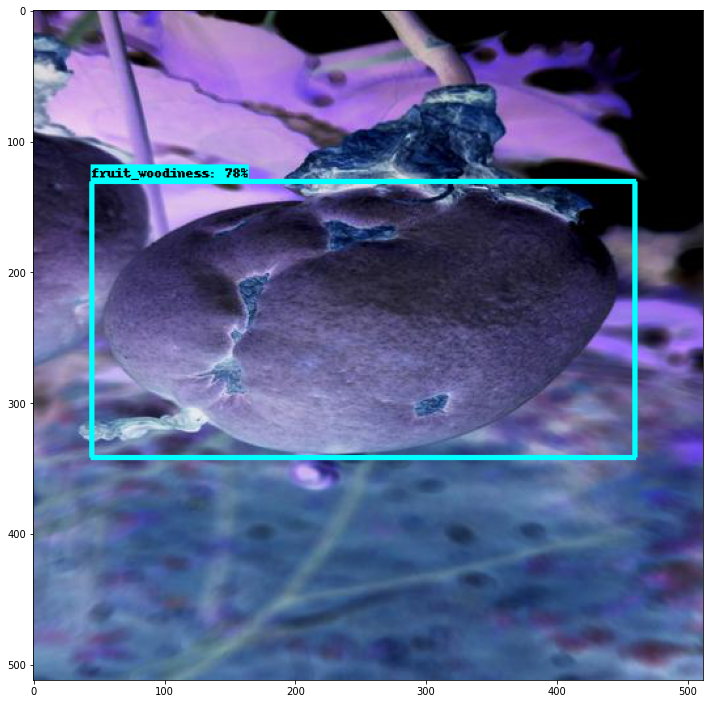

In [78]:
#run detector on test image
#it takes a little longer on the first run and then runs at normal speed. 
import random

TEST_IMAGE_PATHS = glob.glob(f'{testImgPath}*.jpg')
image_path = random.choice(TEST_IMAGE_PATHS)
image_np = load_image_into_numpy_array(image_path)

# Things to try:
# Flip horizontally
# image_np = np.fliplr(image_np).copy()

# Convert image to grayscale
# image_np = np.tile(
#     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

#######################
# TRY INVERT ################
image_np = 255-image_np
########################

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.5,
      agnostic_mode=False,
)

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()

In [79]:
tend = time.time()
print('Elapsed time: ', (tend-t0)/60, ' minutes')

Elapsed time:  153.91122366587322  minutes


In [80]:
detections

{'detection_anchor_indices': <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
 array([[48631, 48700, 48773, 46815, 46815, 48773, 47828, 48488, 47021,
         46866, 39595, 46671, 46964, 48848, 48497, 46964, 46893, 48762,
         47680, 48654, 47452, 48425, 46976, 46677, 46670, 48416, 48546,
         46519, 48654, 48486, 46670, 46519, 46427, 46463, 46677, 48848,
         47596, 46731, 48837, 47535, 46749, 47685, 39938, 47095, 47037,
         48681, 47824, 38910, 47451, 48668, 46532, 48011, 37820, 47448,
         48727, 46972, 48666, 48603, 47095, 46685, 47541, 47741, 46541,
         40364, 48762, 37814, 48666, 48727, 48681, 46533, 48486, 46541,
         46751, 39210, 48604, 46463, 47043, 46686, 46971, 46533, 47247,
         38613, 47462, 39183, 38910, 47595, 46519, 48675, 46697, 38090,
         39621, 48035, 46839, 39911, 38901, 44666, 40364, 42449, 48668,
         48589]], dtype=int32)>,
 'detection_boxes': <tf.Tensor: shape=(1, 100, 4), dtype=float32, numpy=
 array([[[2.56880909e-01,

# Inference

Much is copied from Edwin's inference colab

In [81]:
import pandas as pd

In [82]:
def run_inference_for_single_image(image_path, max_bbox=4, score_threshold=1e-2):
  image_np = load_image_into_numpy_array(image_path)
  input_tensor = tf.convert_to_tensor(
      np.expand_dims(image_np, 0), dtype=tf.float32)
  detections, predictions_dict, shapes = detect_fn(input_tensor)

  label_id_offset = 1
  
  boxes = detections['detection_boxes'][0].numpy() * 512
  classes = (detections['detection_classes'][0].numpy() + label_id_offset).astype(int)
  scores = detections['detection_scores'][0].numpy()
  indices = tf.image.non_max_suppression(boxes, scores, max_output_size=max_bbox, iou_threshold=0.25, score_threshold=score_threshold, name=None).numpy()
  filename = image_path.split('/')[-1].split(".")[0]
  df_output = pd.DataFrame(boxes[indices], columns = ['ymin', 'xmin', 'ymax', 'xmax'])
  df_output['class'] = classes[indices]
  df_output['class'] = df_output['class'].map(lambda x: category_index[x]['name'])
  df_output['confidence'] = scores[indices]
  df_output['Image_ID'] = filename

  return df_output

In [83]:
TEST_IMAGE_PATHS = glob.glob(f'{testImgPath}*.jpg')

In [84]:
run_inference_for_single_image(TEST_IMAGE_PATHS[0])

,ymin,xmin,ymax,xmax,class,confidence,Image_ID
0,180.785675,56.416397,499.964325,498.928345,fruit_brownspot,0.063204,ID_ZTYJSHWW
1,407.712555,26.922821,512.000000,458.407959,fruit_brownspot,0.037059,ID_ZTYJSHWW
2,440.356079,357.419281,512.000000,512.000000,fruit_brownspot,0.035417,ID_ZTYJSHWW
3,447.514221,0.000000,512.000000,206.235901,fruit_brownspot,0.028995,ID_ZTYJSHWW


In [85]:
df_list = []
for image_path in TEST_IMAGE_PATHS:
  df_list.append(run_inference_for_single_image(image_path))
df_output = pd.concat(df_list)[['Image_ID', 'class', 'confidence', 'ymin', 'xmin', 'ymax', 'xmax']]

In [86]:
df_output

,Image_ID,class,confidence,ymin,xmin,ymax,xmax
0,ID_ZTYJSHWW,fruit_brownspot,0.063204,180.785675,56.416397,499.964325,498.928345
1,ID_ZTYJSHWW,fruit_brownspot,0.037059,407.712555,26.922821,512.000000,458.407959
2,ID_ZTYJSHWW,fruit_brownspot,0.035417,440.356079,357.419281,512.000000,512.000000
3,ID_ZTYJSHWW,fruit_brownspot,0.028995,447.514221,0.000000,512.000000,206.235901
0,ID_I8B8LA8C,fruit_brownspot,0.179811,200.551712,0.000000,501.525940,510.910950
...,...,...,...,...,...,...,...
3,ID_QJWLRB4V,fruit_brownspot,0.010961,346.532990,13.676491,511.670258,92.286140
0,ID_VE9GFIUT,fruit_brownspot,0.076910,47.566582,249.815674,238.316620,394.060669
1,ID_VE9GFIUT,fruit_brownspot,0.051315,203.995697,48.583130,484.902679,414.307861
2,ID_VE9GFIUT,fruit_brownspot,0.022113,443.108887,0.000000,512.000000,175.183197


In [87]:
df_output.to_csv(f'{colabPath}/TFsubmissionInvert.csv', encoding='utf-8', index=False)

## Congrats!

Hope you enjoyed this!

--Team [Roboflow](https://roboflow.ai)
